In [1]:
import sys
import os
import random
import json
import matplotlib.pyplot as plt
import numpy as np
# Add the parent directory of AAC/ to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from PDAC.pdac_scheduling_ilp import solve_pdac_ilp
from PDAC.pdac_scheduling_lp import solve_pdac_lp

from AAC.aac_scheduling_greedy import solve_aac_greedy
from AAC.aac_scheduling_ilp import solve_aac_ilp
from AAC.aac_scheduling_lp import solve_aac_lp

In [2]:
start_time = 0
end_time = 1400
max_length = 700
# batch_size = 50

start_size = 10
end_size = 100
step_size = 10

In [3]:
"""
Resources -> This is a list that keeps track of the amount of available resources at each time step

    - The resource curve information will be gathered from the Data/ folder.
"""
# Instantiate the resource curve
path = '../../Input_Data/solar_data.json'
with open(path, 'r') as file:
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

day = 3
resources = total[(24 * day) + start_time : (24 * day) + end_time]

# # Implement a resource curve scaling factor to better fit the jobs
scale_factor = 0.05
resources = [r * scale_factor for r in resources]

In [4]:
# This is The list of job objects that will be scheduled
# They each have a release, deadline, duration and height
path = '../../Input_Data/job_data.json'
with open(path, 'r') as file:
    data = json.load(file)

# Randomly shuffle the jobs so that there is variation between trials
jobs_array = data['jobs']

pdac_inexact = []
pdac_exact = []

aac_exact = []
aac_inexact = []
aac_greedy = []

for batch_size in range(start_size, end_size, step_size):
    random.shuffle(jobs_array)

    pi = solve_pdac_lp(jobs_array, resources, start_time, end_time, max_length, batch_size)
    pe = solve_pdac_ilp(jobs_array, resources, start_time, end_time, max_length, batch_size)

    ag = solve_aac_greedy(jobs_array, resources, start_time, end_time, max_length, batch_size)
    ae = solve_aac_ilp(jobs_array, resources, start_time, end_time, max_length, batch_size)
    ai = solve_aac_lp(jobs_array, resources, start_time, end_time, max_length, batch_size)

    pdac_inexact.append(pi)
    pdac_exact.append(pe)

    aac_greedy.append(ag)
    aac_exact.append(ae)
    aac_inexact.append(ai)


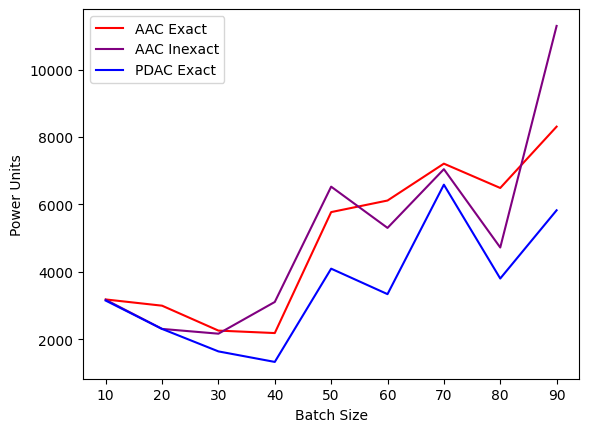

In [6]:
job_graph_xvalues = np.array([i for i in range(start_size, end_size, step_size)])

# plt.plot(job_graph_xvalues, aac_greedy, label="AAC Greedy", color='green')
plt.plot(job_graph_xvalues, aac_exact, label="AAC Exact", color='red')
plt.plot(job_graph_xvalues, aac_inexact, label="AAC Inexact", color='purple')

plt.plot(job_graph_xvalues, pdac_exact, label="PDAC Exact", color='blue')
# plt.plot(job_graph_xvalues, pdac_inexact, label="PDAC Inexact", color='orange')

plt.xlabel("Batch Size")
plt.ylabel("Power Units")
plt.legend()
plt.show()